*Assignment 3 297.201*



Group 11
- Amaz Salman 24001042
- Daniel Soung-Yun Kim 24016358
- Forest Bennett 23010240
- Karolina Cardenas Rios 20014550

In [1]:
from unittest.mock import inplace
from IPython.display import display, HTML
from tqdm import tqdm
import time
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import json
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, brier_score_loss
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from pylab import rcParams

rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 1.2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'DejaVu Sans'
rcParams['figure.figsize'] = 5,3
rcParams['font.size'] = 10

In [5]:
rcParams['axes.labelsize'] = 'medium'
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8

## Data Acquisition

In [6]:
#Amaz
def get_fighter_links():
    base_url = "http://www.ufcstats.com/statistics/fighters?char={}&page=all"
    letters = 'abcdefghijklmnopqrstuvwxyz'
    fighter_links = []

    for letter in letters:
        url = base_url.format(letter)
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, 'html.parser')
            table = soup.find('table', class_='b-statistics__table')
            if table:
                links = table.find_all('a')
                for link in links:
                    href = link.get('href')
                    if href and 'fighter-details' in href:
                        fighter_links.append(href)
            time.sleep(0.5)
        except Exception as e:
            print(f"Ran into an error while checking letter {letter}: {e}")

    return list(set(fighter_links))


In [7]:
#Amaz
def get_fighter_data(fighter_url):
    response = requests.get(fighter_url, timeout=10)
    soup = BeautifulSoup(response.content, 'html.parser')

    name = soup.find('span', class_='b-content__title-highlight')
    name = name.text.strip() if name else None

    record = soup.find('span', class_='b-content__title-record')
    record = record.text.strip().replace('Record: ', '') if record else None

    stats = soup.find_all('li', class_='b-list__box-list-item b-list__box-list-item_type_block')
    data = {'Name': name, 'Record': record, 'Fighter URL': fighter_url}

    for stat in stats:
        parts = stat.text.strip().split(':')
        if len(parts) == 2:
            key = parts[0].strip()
            value = parts[1].strip()
            data[key] = value

    return data

In [8]:
#Amaz
def main():
    print("Grabbing all the fighter profile links...")
    fighter_links = get_fighter_links()
    print(f"Found {len(fighter_links)} fighters.")

    fighters_data = []
    errors = []

    for link in tqdm(fighter_links):
        try:
            fighter = get_fighter_data(link)
            fighters_data.append(fighter)
        except Exception as e:
            print(f"Couldn’t get data from {link}: {e}")
            errors.append((link, str(e)))
        time.sleep(0.5)

    df = pd.DataFrame(fighters_data)
    df.to_csv("./csv/ufc_fighters_dataset.csv", index=False)
    print("Done! Saved everything to ufc_fighters_dataset.csv")

    if errors:
        print(f"Had trouble with {len(errors)} links. You might want to check the log.")

main()

Grabbing all the fighter profile links...
Found 4354 fighters.


100%|██████████| 4354/4354 [1:19:54<00:00,  1.10s/it]

Done! Saved everything to ufc_fighters_dataset.csv


In [9]:
#Karolina - I followed the instruction from sportradar to consume the API
base_api_url = 'https://api.sportradar.com/mma/trial/v2/en'
headers = {
    "accept": "application/json",
    "x-api-key": 'FYcFfXYU39pCxyf5QAYnJXWNlQs0IBdBPNU6wloe'
}

In [10]:
#Karolina
def get_all_seasons():
    url_seasons = base_api_url + "/seasons.json"
    response_seasons = requests.get(url_seasons, headers=headers)
    seasons_content = json.loads(response_seasons.content)
    seasons_values = seasons_content.get('seasons')
    seasons_result = []
    for season in seasons_values:
        start_date = season.get("start_date")
        season_name = season.get('name')
        seasons_result.append({
            'Date': start_date,
            'Name': season_name
        })
    return seasons_result


In [11]:
#Karolina
def get_all_fights_by_date(date):
    url_fights = base_api_url + '/schedules/' + date + '/summaries.json'
    response_fights = requests.get(url_fights, headers=headers)
    fights_content = json.loads(response_fights.content)
    fights_values = fights_content.get('summaries')
    fights_results = []
    if fights_values is not None:
        for fight in fights_values:
            sport_event = fight.get('sport_event')
            sport_event_context = sport_event.get('sport_event_context')
            competition = sport_event_context.get('competition')
            competition_name = competition.get('name')
            competitors = sport_event.get('competitors')
            sport_event_status = fight.get('sport_event_status')
            event_status = sport_event_status.get('status')
            if event_status == 'closed':
                winner_id = sport_event_status.get('winner_id')
                final_round = sport_event_status.get('final_round')
                final_round_length = sport_event_status.get('final_round_length')
                method = sport_event_status.get('method')
                scheduled_length = sport_event_status.get('scheduled_length')
                weight_class = sport_event_status.get('weight_class')
                winner = None
                loser = None
                for compet in competitors:
                    if compet.get('id') == winner_id:
                        winner = compet
                    else:
                        loser = compet
                if winner is not None and loser is not None:
                    winner_name = winner.get('name')
                    winner_abbrev = winner.get('abbreviation')
                    winner_gender = winner.get('gender')
                    winner_qualifier = winner.get('qualifier')
                    loser_name = loser.get('name')
                    loser_abbrev = loser.get('abbreviation')
                    loser_gender = loser.get('gender')
                    loser_qualifier = loser.get('qualifier')
                    loser_id = loser.get('id')
                    statistics = fight.get('statistics')
                    if statistics is not None:
                        totals = statistics.get('totals')
                        if totals is not None:
                            stats_comp = totals.get('competitors')
                            winner_stats = None
                            loser_stats = None
                            for comp in stats_comp:
                                if comp.get('id') == winner_id:
                                    winner_stats = comp.get('statistics')
                                else:
                                    loser_stats = comp.get('statistics')
                            if winner_stats is not None and loser_stats is not None:
                                winner_control = winner_stats.get('control')
                                winner_knockdowns = winner_stats.get('knockdowns')
                                winner_significant_strike_percentage = winner_stats.get('significant_strike_percentage')
                                winner_significant_strikes = winner_stats.get('significant_strikes')
                                winner_significant_strikes_attempted = winner_stats.get('significant_strikes_attempted')
                                winner_submission_attempts = winner_stats.get('submission_attempts')
                                winner_takedown_percentage = winner_stats.get('takedown_percentage')
                                winner_takedowns = winner_stats.get('takedowns')
                                winner_takedowns_attempted = winner_stats.get('takedowns_attempted')
                                winner_total_strike_percentage = winner_stats.get('total_strike_percentage')
                                winner_total_strikes = winner_stats.get('total_strikes')
                                winner_total_strikes_attempted = winner_stats.get('total_strikes_attempted')
                                loser_control = loser_stats.get('control')
                                loser_knockdowns = loser_stats.get('knockdowns')
                                loser_significant_strike_percentage = loser_stats.get('significant_strike_percentage')
                                loser_significant_strikes = loser_stats.get('significant_strikes')
                                loser_significant_strikes_attempted = loser_stats.get('significant_strikes_attempted')
                                loser_submission_attempts = loser_stats.get('submission_attempts')
                                loser_takedown_percentage = loser_stats.get('takedown_percentage')
                                loser_takedowns = loser_stats.get('takedowns')
                                loser_takedowns_attempted = loser_stats.get('takedowns_attempted')
                                loser_total_strike_percentage = loser_stats.get('total_strike_percentage')
                                loser_total_strikes = loser_stats.get('total_strikes')
                                loser_total_strikes_attempted = loser_stats.get('total_strikes_attempted')

                                fights_results.append({
                                    "date": date,
                                    'competition' : competition_name,
                                    "winner": winner_name,
                                    'winner_abbreviation': winner_abbrev,
                                    'winner_gender': winner_gender,
                                    "winner_qualifier": winner_qualifier,
                                    'winner_id': winner_id,
                                    'winner_control': winner_control,
                                    'winner_knockdowns': winner_knockdowns,
                                    'winner_significant_strike_percentage': winner_significant_strike_percentage,
                                    'winner_significant_strikes': winner_significant_strikes,
                                    'winner_significant_strikes_attempted': winner_significant_strikes_attempted,
                                    'winner_submission_attempts': winner_submission_attempts,
                                    'winner_takedown_percentage': winner_takedown_percentage,
                                    'winner_takedowns': winner_takedowns,
                                    'winner_takedowns_attempted': winner_takedowns_attempted,
                                    'winner_total_strike_percentage': winner_total_strike_percentage,
                                    'winner_total_strikes': winner_total_strikes,
                                    'winner_total_strikes_attempted': winner_total_strikes_attempted,
                                    "loser": loser_name,
                                    'loser_abbreviation': loser_abbrev,
                                    'loser_gender': loser_gender,
                                    "loser_qualifier": loser_qualifier,
                                    'loser_id': loser_id,
                                    'loser_control': loser_control,
                                    'loser_knockdowns': loser_knockdowns,
                                    'loser_significant_strike_percentage': loser_significant_strike_percentage,
                                    'loser_significant_strikes': loser_significant_strikes,
                                    'loser_significant_strikes_attempted': loser_significant_strikes_attempted,
                                    'loser_submission_attempts': loser_submission_attempts,
                                    'loser_takedown_percentage': loser_takedown_percentage,
                                    'loser_takedowns': loser_takedowns,
                                    'loser_takedowns_attempted': loser_takedowns_attempted,
                                    'loser_total_strike_percentage': loser_total_strike_percentage,
                                    'loser_total_strikes': loser_total_strikes,
                                    'loser_total_strikes_attempted': loser_total_strikes_attempted,
                                    'final_round': final_round,
                                    'final_round_length': final_round_length,
                                    'method': method,
                                    'scheduled_length': scheduled_length,
                                    "weight_class": weight_class,
                                })

    return fights_results

In [12]:
#Karolina
def get_all_fights_data():
    seasons = get_all_seasons()
    all_fights = []
    for season in seasons:
        season_fights = get_all_fights_by_date(season['Date'])
        all_fights.extend(season_fights)
    return all_fights


In [13]:
#Karolina
all_fights_data = get_all_fights_data()
df_all_fights = pd.DataFrame(all_fights_data)
df_all_fights.to_csv('./csv/df_all_fights.csv', index= False)
df_all_fights

,date,competition,winner,winner_abbreviation,winner_gender,winner_qualifier,winner_id,winner_control,winner_knockdowns,winner_significant_strike_percentage,...,loser_takedowns,loser_takedowns_attempted,loser_total_strike_percentage,loser_total_strikes,loser_total_strikes_attempted,final_round,final_round_length,method,scheduled_length,weight_class
0,2019-03-16,UFC Fight Night - London,"Grundy, Mike",GRU,male,home,sr:competitor:539717,0:00,1,52.38,...,0,1,23.36,25,107,2,4:42,ko_tko,3,featherweight(136-145)
1,2019-03-16,UFC Fight Night - London,"McCann, Molly",MCC,female,home,sr:competitor:441632,0:00,0,54.31,...,0,0,32.35,77,238,3,5:00,decision_unanimous,3,flyweight(116-125)
2,2019-03-16,UFC Fight Night - London,"Ige, Dan",IGE,male,away,sr:competitor:539711,0:00,0,62.50,...,1,1,54.55,6,11,1,1:17,submission,3,featherweight(136-145)
3,2019-03-16,UFC Fight Night - London,"Safarov, Saparbek",SAF,male,away,sr:competitor:304962,0:00,0,81.40,...,0,0,55.56,20,36,3,5:00,decision_unanimous,3,light_heavyweight(186-205)
4,2019-03-16,UFC Fight Night - London,"Diakiese, Marc",DIA,male,home,sr:competitor:290246,0:00,1,59.43,...,1,3,33.80,24,71,3,5:00,decision_unanimous,3,lightweight(146-155)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2025-05-17,UFC Fight Night: Burns vs. Morales,"Delvalle, Yadier",DEL,male,home,sr:competitor:1191035,01:21,0,75.00,...,0,0,30.00,3,10,1,2:54,submission,3,featherweight(136-145)
1544,2025-05-17,UFC Fight Night: Burns vs. Morales,"Gordon, Jared",GOR,male,home,sr:competitor:333581,02:36,1,53.85,...,0,0,68.75,11,16,1,3:37,ko_tko,3,lightweight(146-155)
1545,2025-05-17,UFC Fight Night: Burns vs. Morales,"Green, Gabriel",GRE,male,home,sr:competitor:658401,02:12,0,44.44,...,2,3,68.75,33,48,2,3:43,submission,3,lightweight(146-155)
1546,2025-05-17,UFC Fight Night: Burns vs. Morales,"Costa, Melquizael",COS,male,away,sr:competitor:980481,00:23,0,50.00,...,3,10,42.08,85,202,3,5:00,decision_unanimous,3,featherweight(136-145)


In [14]:
#Karolina
all_fighters = pd.read_csv('./csv/ufc_fighters_dataset.csv')
all_fights = pd.read_csv('./csv/df_all_fights.csv')

In [15]:
#Karolina
winners = all_fights[['winner', 'winner_id', 'weight_class']]
losers = all_fights[['loser', 'loser_id', 'weight_class']]
all_fighters['N_Name'] = ""
all_fighters['id'] = np.NaN
all_fighters['weight_class']=""
for i, f in all_fighters.iterrows():
    f_name = f['Name']
    n_parts = f_name.split()
    surname = n_parts.pop()
    first_name = ''.join(n_parts)
    full_name = surname + ', ' + first_name
    all_fighters.at[i,'N_Name'] = full_name
    w = winners[winners['winner']== full_name]
    if not w.empty:
        w_first = w.iloc[0]
        all_fighters.at[i,'id'] = w_first['winner_id']
        all_fighters.at[i, 'weight_class'] = w_first['weight_class']
    else:
        l = losers[losers['loser']== full_name]
        if not l.empty:
            l_first = l.iloc[0]
            all_fighters.at[i,'id'] = l_first['loser_id']
            all_fighters.at[i, 'weight_class'] = l_first['weight_class']


all_fighters = all_fighters.dropna(subset=['id'])
all_fighters.to_csv('./csv/all_fighters.csv', index=False)

## Data Engineering

In [16]:
#Forest
data = pd.read_csv('./csv/df_all_fights.csv')
data

,date,competition,winner,winner_abbreviation,winner_gender,winner_qualifier,winner_id,winner_control,winner_knockdowns,winner_significant_strike_percentage,...,loser_takedowns,loser_takedowns_attempted,loser_total_strike_percentage,loser_total_strikes,loser_total_strikes_attempted,final_round,final_round_length,method,scheduled_length,weight_class
0,2019-03-16,UFC Fight Night - London,"Grundy, Mike",GRU,male,home,sr:competitor:539717,0:00,1,52.38,...,0,1,23.36,25,107,2,4:42,ko_tko,3,featherweight(136-145)
1,2019-03-16,UFC Fight Night - London,"McCann, Molly",MCC,female,home,sr:competitor:441632,0:00,0,54.31,...,0,0,32.35,77,238,3,5:00,decision_unanimous,3,flyweight(116-125)
2,2019-03-16,UFC Fight Night - London,"Ige, Dan",IGE,male,away,sr:competitor:539711,0:00,0,62.50,...,1,1,54.55,6,11,1,1:17,submission,3,featherweight(136-145)
3,2019-03-16,UFC Fight Night - London,"Safarov, Saparbek",SAF,male,away,sr:competitor:304962,0:00,0,81.40,...,0,0,55.56,20,36,3,5:00,decision_unanimous,3,light_heavyweight(186-205)
4,2019-03-16,UFC Fight Night - London,"Diakiese, Marc",DIA,male,home,sr:competitor:290246,0:00,1,59.43,...,1,3,33.80,24,71,3,5:00,decision_unanimous,3,lightweight(146-155)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2025-05-17,UFC Fight Night: Burns vs. Morales,"Delvalle, Yadier",DEL,male,home,sr:competitor:1191035,01:21,0,75.00,...,0,0,30.00,3,10,1,2:54,submission,3,featherweight(136-145)
1544,2025-05-17,UFC Fight Night: Burns vs. Morales,"Gordon, Jared",GOR,male,home,sr:competitor:333581,02:36,1,53.85,...,0,0,68.75,11,16,1,3:37,ko_tko,3,lightweight(146-155)
1545,2025-05-17,UFC Fight Night: Burns vs. Morales,"Green, Gabriel",GRE,male,home,sr:competitor:658401,02:12,0,44.44,...,2,3,68.75,33,48,2,3:43,submission,3,lightweight(146-155)
1546,2025-05-17,UFC Fight Night: Burns vs. Morales,"Costa, Melquizael",COS,male,away,sr:competitor:980481,00:23,0,50.00,...,3,10,42.08,85,202,3,5:00,decision_unanimous,3,featherweight(136-145)


In [17]:
#Forest
data['strike_accuracy_diff '] = data['winner_significant_strike_percentage'] - data['loser_significant_strike_percentage']
data['total_strike_accuracy_diff  '] = data['winner_total_strike_percentage'] - data['loser_total_strike_percentage']
data['knockdowns_diff'] = data['winner_knockdowns'] - data['loser_knockdowns']
data['takedown_accuracy_diff'] = data['winner_takedown_percentage'] - data['loser_takedown_percentage']
data['takedowns_diff'] = data['winner_takedowns'] - data['loser_takedowns']
data['submission_attempts_diff'] = data['winner_submission_attempts'] - data['loser_submission_attempts']
data.to_csv('./csv/df_all_fights.csv', index=False)

## Data Modelling

In [18]:
#Daniel&Amaz
df = pd.read_csv('./csv/df_all_fights.csv')
df.columns = df.columns.str.strip()

num_cols = [
    'strike_accuracy_diff',
    'total_strike_accuracy_diff',
    'knockdowns_diff',
    'takedown_accuracy_diff',
    'takedowns_diff',
    'submission_attempts_diff'
]
cat_cols = ['weight_class', 'method']

df_clean = df[num_cols + cat_cols].dropna()

X_pos = df_clean.copy()
y_pos = np.ones(len(X_pos))

X_neg = df_clean.copy()
X_neg[num_cols] = -X_neg[num_cols]
y_neg = np.zeros(len(X_neg))

X = pd.concat([X_pos, X_neg], ignore_index=True)
y = np.concatenate([y_pos, y_neg])


In [19]:
#Daniel&Amaz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess = ColumnTransformer([
    ('scale', StandardScaler(), num_cols),
    ('encode', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [20]:
#Daniel&Amaz
models_to_test = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

In [21]:
#Daniel&Amaz
model_scores = {}

for label, model in models_to_test.items():
    pipeline = ImbPipeline([
        ('prep', preprocess),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    f1 = f1_score(y_test, preds)
    model_scores[label] = f1

    print(f"== {label} ==")
    print(classification_report(y_test, preds, digits=3))
    print("-" * 50)

== Naive Bayes ==
              precision    recall  f1-score   support

         0.0      0.724     0.764     0.743       292
         1.0      0.779     0.741     0.759       328

    accuracy                          0.752       620
   macro avg      0.751     0.752     0.751       620
weighted avg      0.753     0.752     0.752       620

--------------------------------------------------
== KNN ==
              precision    recall  f1-score   support

         0.0      0.761     0.798     0.779       292
         1.0      0.812     0.777     0.794       328

    accuracy                          0.787       620
   macro avg      0.787     0.788     0.787       620
weighted avg      0.788     0.787     0.787       620

--------------------------------------------------
== Random Forest ==
              precision    recall  f1-score   support

         0.0      0.788     0.839     0.813       292
         1.0      0.848     0.799     0.823       328

    accuracy                    

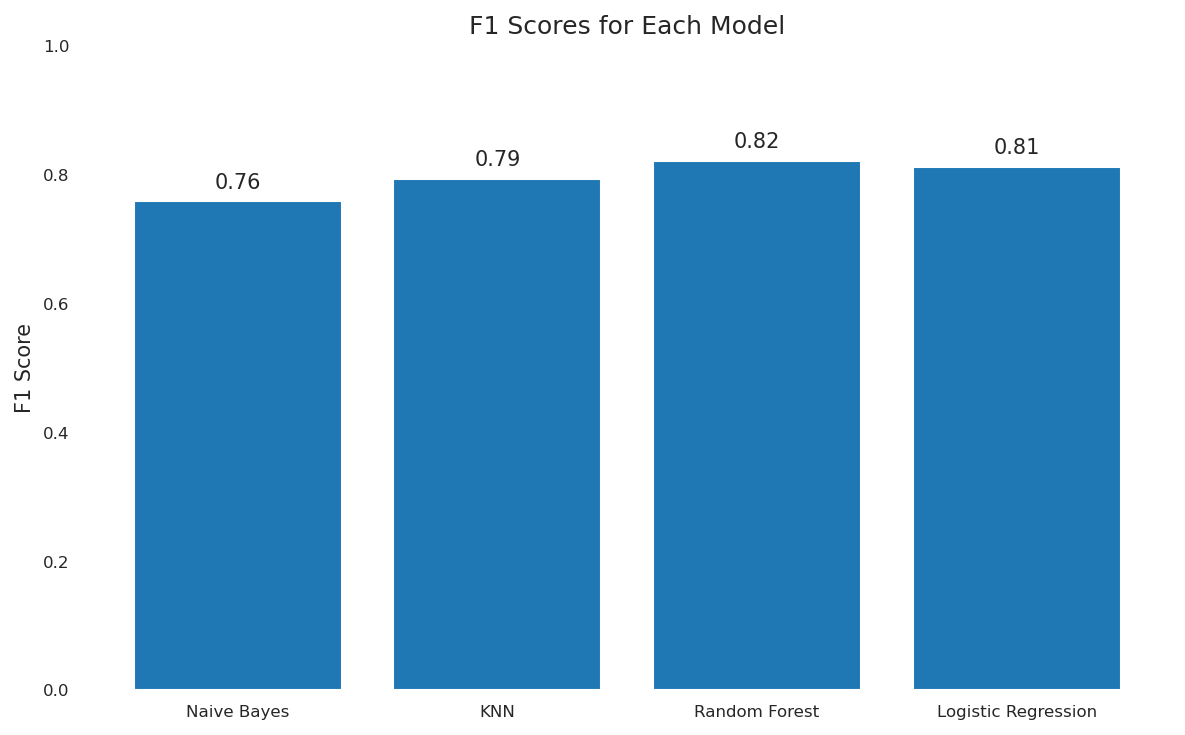

In [22]:
#Daniel&Amaz
plt.figure(figsize=(8, 5))
bars = plt.bar(model_scores.keys(), model_scores.values())
plt.ylim(0, 1)
plt.title("F1 Scores for Each Model")
plt.ylabel("F1 Score")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [24]:
#Daniel&Amaz
df = pd.read_csv('./csv/df_all_fights.csv')
df.columns = df.columns.str.strip()

num_cols = [
    'strike_accuracy_diff',
    'total_strike_accuracy_diff',
    'knockdowns_diff',
    'takedown_accuracy_diff',
    'takedowns_diff',
    'submission_attempts_diff'
]

cat_cols = ['weight_class', 'method']

base_feats = df[num_cols + cat_cols].dropna()

y_win = np.ones(len(base_feats), dtype=int)

flipped_feats = base_feats.copy()
flipped_feats[num_cols] = -flipped_feats[num_cols]

y_lose = np.zeros(len(flipped_feats), dtype=int)

X_total = pd.concat([base_feats, flipped_feats], ignore_index=True)
y_total = np.concatenate([y_win, y_lose])

In [25]:
#Daniel&Amaz
feat_transform = ColumnTransformer([
    ('std', StandardScaler(), num_cols),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe_rf = Pipeline([
    ('xform', feat_transform),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

cal_rf = CalibratedClassifierCV(estimator=pipe_rf, method='sigmoid', cv=5)

In [26]:
#Daniel&Amaz
prob_preds = cross_val_predict(cal_rf, X_total, y_total, cv=5, method='predict_proba')[:, 1]
final_preds = (prob_preds >= 0.5).astype(int)

print("== Random Forest with Calibration ==")
print(classification_report(y_total, final_preds))
print("Brier Score:", brier_score_loss(y_total, prob_preds))


== Random Forest with Calibration ==
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1548
           1       0.83      0.83      0.83      1548

    accuracy                           0.83      3096
   macro avg       0.83      0.83      0.83      3096
weighted avg       0.83      0.83      0.83      3096

Brier Score: 0.12089204345657771


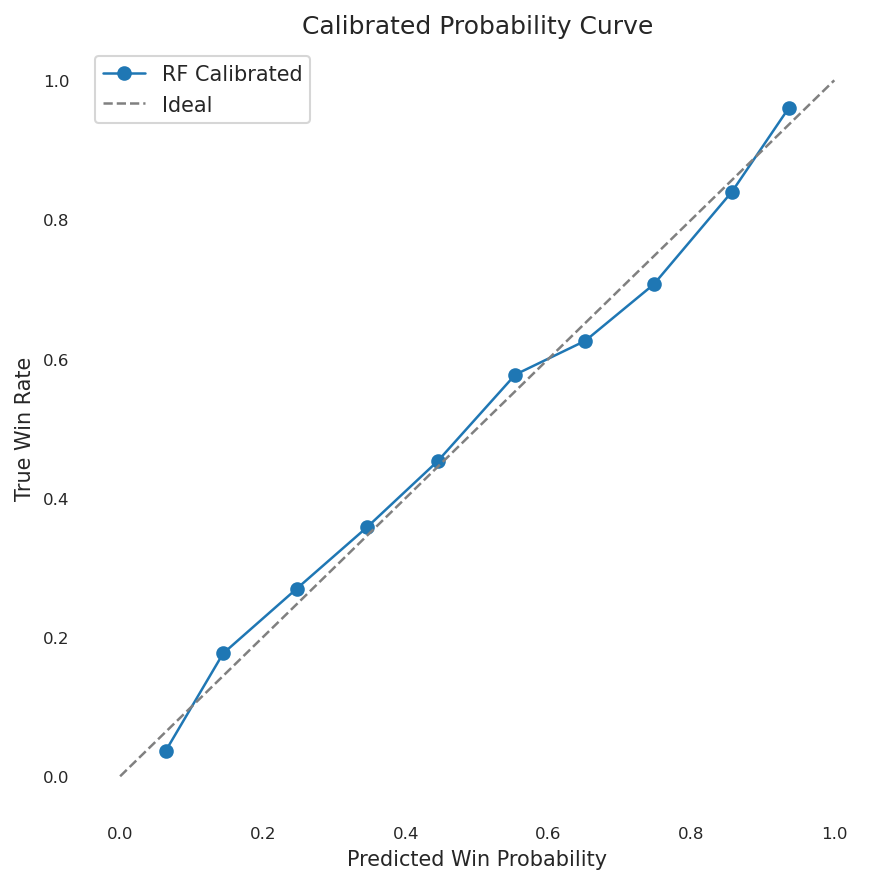

In [27]:
#Daniel&Amaz
cal_y, cal_x = calibration_curve(y_total, prob_preds, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(cal_x, cal_y, 'o-', label='RF Calibrated')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal')
plt.title("Calibrated Probability Curve")
plt.xlabel("Predicted Win Probability")
plt.ylabel("True Win Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
#Daniel
import joblib

cal_rf.fit(X_total, y_total)
joblib.dump(cal_rf, "model.pkl")
print("model.pkl saved")

model.pkl saved


# Report

## Executive Summary

This report for group 11 shows the development of an app that predicts the winner of a UFC match. The project aims to predict the winner in a fight in the same category or weight class. We used relevant statistics to train the models, and after we tried several models and evaluated them, we chose the model that provided the best score to predict the winner.

## Introduction and Research questions


- Can we do like a prediction of UFC matches or anything with a 1 1 match? # This was the first question in the chat to decide the topic
- Will we try to predict the winner based on the table for each fighter, such as wins by knockout, submission, and first-round wins, or would we need more data?
- What kind of stats do we need to show in the app?
- What kind of stats do we need to train the model?
- What factors best predict the fighter's win probabilities?
- Is the category/weight class used to compare two fighters and predict the winner?

1. We created two dataframes, one containing all the data about the fighters(all_fighters), such as Height, weight, reach, stance, DOB,	SLpM, and Str. Acc,	SApM, Str. Def, TD Avg, TD Acc, TD Def, Sub. Avg, N_Name, id and weight_class. We included the weight class because it is super important to compare two fighters but in the same category.

2. The another dataframe (df_all_fights)contains the data about the fights like competition, winner, winner_abbreviation,	winner_gender,	winner_qualifier, winner_id,	winner_control,	winner_knockdowns,	winner_significant_strike_percentage,	winner_significant_strikes,	winner_significant_strikes_attempted,	winner_submission_attempts,	winner_takedown_percentage,	winner_takedowns,	winner_takedowns_attempted,	winner_total_strike_percentage,	winner_total_strikes,	winner_total_strikes_attempted,	loser,	loser_abbreviation,	loser_gender,	loser_qualifier,	loser_id,	loser_control,	loser_knockdowns,	loser_significant_strike_percentage,	loser_significant_strikes,	loser_significant_strikes_attempted, loser_submission_attempts,	loser_takedown_percentage,	loser_takedowns, loser_takedowns_attempted,	loser_total_strike_percentage, loser_total_strikes,loser_total_strikes_attempted,	final_round	final_round_length,	method,	scheduled_length and weight_class.
3. In this dataframe(df_all_fights), we created new variables to train the model, such as:
- strike_accuracy_diff
- total_strike_accuracy_diff
- knockdowns_diff
- takedown_accuracy_diff
- takedowns_diff
- submission_attempts_diff.
We also used these tweo variables in the model:
- Method
- Weight_class

## Team communication and code sharing


- We decided to communicate via WhatsApp group from day 1.
- We decided to share and keep the code in GitHub, which is public and all the contributions are saved there. https://github.com/KarolinaCar/UFCprediction
- We decided to create an app based on the mockup that is available in the zip file



## Analyses

We needed to analyse the data we got from the acquisition process to develop an accurate prediction app. The dataframe included detailed stats specific to each fight, and we looked into how we could use this data to create new variables relevant for the models. At first, our dataframes didn’t include all the necessary information, so we focused on acquiring the correct data. Once we had the right data, we performed feature engineering. With the data prepared and the models trained, we implemented evaluation metrics to compare their performance, such as accuracy, precision, recall, F1-score, and support. After evaluating the F1-scores for all models, we chose the one with the best score, the Random Forest model. Also, during the front-end part, we realised that the user needed to select the weight class before choosing the two fighters and getting the predictions. In the initial mockup, we did not consider this feature in our app, but we implemented it because it was necessary to improve the prediction.

## Conclusions

We are satisfied with the project's results. Although we were already familiar with Jupyter Notebooks and Python code, we had never used Streamlit to develop an application before. Integrating Python, Jupyter Notebook, and Streamlit to build an app that predicts the winner between two fighters from the same weight class was a big achievement for us.

We believe we had excellent data and solid models. However, we also know that by improving the quality and depth of the data, we could get results that are even closer to the actual outcomes of real UFC fights.

## Problems we encounter in the project

1. As a group, we worked hard to get the data. We all tried to get the correct data for the project until we realised that Forest and Karolina got the same table from http://ufcstats.com/statistics/fighters?page=all. After that, we decided to divide the jobs, but we were always available in the WhatsApp group in case one member got stuck on the corresponding task.
2. We found a good API source called Sportradar, where we got good and relevant data, but we have limited calls to the API, so we decided to save the dataframe in CSV files.
3. Here we will show all the code for scraping and consuming APIs from all the members that we did not use (At the top of the code, we added the name of the code's creator).

In [29]:
# Karolina
url_ranking = "http://ufcstats.com/statistics/fighters?page=all"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
response_ranking = requests.get(url_ranking, headers=headers)

# Always check if the request was successful
if response_ranking.status_code != 200:
    print(f"Error: Received status code {response_ranking.status_code}")
    exit()

print(f"Response status: {response_ranking.status_code}")

Response status: 200


In [ ]:
# Karolina & Forest
fighters_page = response_ranking.content
scraping = BeautifulSoup(fighters_page, "lxml")
tables_fighters = scraping.find_all('table')
tables_fighters_df = pd.read_html(str(tables_fighters))
fighters_table = tables_fighters_df[0]
fighters_table

In [ ]:
# Karolina
base_api_url = 'https://api.sportradar.com/mma/trial/v2/en'
headers = {
    "accept": "application/json",
    "x-api-key": 'FYcFfXYU39pCxyf5QAYnJXWNlQs0IBdBPNU6wloe'
}

In [ ]:
# Karolina
url = base_api_url + "/rankings.json"

response = requests.get(url, headers=headers)

In [ ]:
#Karolina
def get_rankings():

    res = json.loads(response.content)
    rankings = res.get('rankings',[])

    records = []
    for cat_ranking in rankings:
        category = cat_ranking.get('name')
        year = cat_ranking.get('year')
        week = cat_ranking.get('week')
        competitor_rankings = cat_ranking.get('competitor_rankings', [])
        for competitor in competitor_rankings:
            rank = competitor.get('rank')
            comp = competitor.get('competitor')
            comp_id = comp.get('id')
            name = comp.get('name')
            gender = comp.get('gender')
            records.append({
                'Name': name,
                'Id': comp_id,
                'Ranking': rank,
                "Gender": gender,
                'Category': category,
                'Year': year,
                "Week": week
            })
    return records

In [ ]:
#Karolina
df_rankings_fighters = pd.DataFrame(get_rankings())
df_rankings_fighters.sort_values(by='Id', ascending=False)
df_rankings_fighters.to_csv('./csv/df_ranking_fighters.csv', index=False)
df_rankings_fighters

In [ ]:
#Karolina
def get_profiles():
    profiles = []
    for index, fighter in df_rankings_fighters.iterrows():
        fighterId = fighter['Id'].replace(":", "%3A")
        profile_url = "https://api.sportradar.com/mma/trial/v2/en/competitors/" + fighterId + "/profile.json"
        response_fighter = requests.get(profile_url, headers=headers)
        res_fighter = json.loads(response_fighter.content)
        competitor_profile = res_fighter.get('competitor')
        if competitor_profile is not None:
            profile_id = competitor_profile.get('id')
            info = res_fighter.get('info')
            country = info.get('birth_country')
            Birth_country_code = info.get('birth_country_code')
            DOB = info.get('birth_date')
            reach = info.get('reach')
            Height = info.get('height')
            Weight = info.get('weight')
            Nickname = info.get('nickname')
            record = res_fighter.get('record')
            Wins = record.get('wins')
            Draws = record.get('draws')
            Losses = record.get('losses')
            profiles.append({
                'Id': profile_id,
                'Country': country,
                'Brith_Code': Birth_country_code,
                'DOB': DOB,
                'Reach': reach,
                'Height': Height,
                'Weight': Weight,
                'Nickname': Nickname,
                'Wins': Wins,
                'Draws': Draws,
                'Losses': Losses
            })
    return profiles

In [ ]:
#Karolina
df_profiles_fighters = pd.DataFrame(get_profiles())
df_profiles_fighters.to_csv('./csv/df_profiles_fighters.csv', index=False)
df_profiles_fighters

In [ ]:
#Karolina
#In the Dataframe fighter_df_info we have the best 15 rankings per category
fighters_df = pd.merge(df_rankings_fighters, df_profiles_fighters, on='Id', how='left')
fighters_df_info = fighters_df.drop_duplicates(subset=['Id', 'Category'])
fighters_df_info = fighters_df_info.rename(columns={'Year': 'Year_Ranking', "Week": 'Week_ranking'})
fighters_df_info

In [ ]:
#Forest
url = "http://www.ufcstats.com/statistics/fighters?char=a&page=all"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers)

# Always check if the request was successful
if response.status_code != 200:
    print(f"Error: Received status code {response.status_code}")
    exit()

print(f"Response status: {response.status_code}")

In [ ]:
#Forest
page = response.content
scraping = BeautifulSoup(page, "lxml")
scraping

In [ ]:
#Forest
def create_fighter_dataframe(soup):
    # Define the column names based on the table headers
    columns = ['First', 'Last', 'Nickname', 'HT', 'WT', 'Reach', 'Stance', 'W', 'L', 'D', 'Belt']

    # Initialize an empty list to store fighter data
    fighters_data = []

    # Find the table containing fighter data
    table = soup.find('table', {'class': 'b-statistics__table'})

    # Find all table rows in the tbody
    rows = table.find('tbody').find_all('tr', {'class': 'b-statistics__table-row'})

    for row in rows:
        # Skip empty separator rows
        if row.find('td', {'class': 'b-statistics__table-col_type_clear'}):
            continue

        # Extract all columns from the row
        cols = row.find_all('td', {'class': 'b-statistics__table-col'})

        # For each column, get the text and clean it up
        fighter_data = []
        for i, col in enumerate(cols):
            text = col.get_text(strip=True)

            # Handle special cases
            if i == 3 or i == 5:  # HT or Reach columns with '--'
                text = None if text == '--' else text
            elif i == 4:  # WT column - remove 'lbs.' and convert to number
                text = None if text == '--' else text.replace(' lbs.', '')
            elif i in (7, 8, 9):  # W, L, D columns - convert to integers
                text = int(text) if text else 0

            fighter_data.append(text)

        # Only add if we have all expected columns
        if len(fighter_data) == len(columns):
            fighters_data.append(fighter_data)

    df = pd.DataFrame(fighters_data, columns=columns)

    return df

df = create_fighter_dataframe(scraping)
df

In [ ]:
#Forest
url2 = "http://www.ufcstats.com/fighter-details/15df64c02b6b0fde"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
response2 = requests.get(url2, headers=headers)

# Always check if the request was successful
if response2.status_code != 200:
    print(f"Error: Received status code {response2.status_code}")
    exit()

print(f"Response status: {response2.status_code}")

In [ ]:
#Forest
page2 = response2.content
scraping2 = BeautifulSoup(page2, "lxml")
scraping2

In [ ]:
#Forest
import time
import re
df = pd.read_csv('./csv/fighters_df_info.csv')

# Initialize new columns for the stats
stats_columns = ['SLpM', 'Str_Acc', 'SApM', 'Str_Def', 'TD_Avg', 'TD_Acc', 'TD_Def', 'Sub_Avg']
for col in stats_columns:
    if col not in df.columns:
        df[col] = None

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

def get_fighter_urls_for_letter(letter):
    """Get all fighter URLs for a specific starting letter"""
    url = f"http://ufcstats.com/statistics/fighters?char={letter}&page=all"
    try:
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Error fetching {letter}: Status {response.status_code}")
            return {}

        soup = BeautifulSoup(response.content, 'html.parser')
        fighters = {}

        # Find all fighter links in the table
        table = soup.find('table', {'class': 'b-statistics__table'})
        if table:
            rows = table.find_all('tr', {'class': 'b-statistics__table-row'})
            for row in rows:
                cols = row.find_all('td', {'class': 'b-statistics__table-col'})
                if len(cols) >= 2:  # At least first and last name columns
                    first_name = cols[0].get_text(strip=True)
                    last_name = cols[1].get_text(strip=True)
                    link = cols[0].find('a')
                    if link and 'href' in link.attrs:
                        name_key = f"{last_name}, {first_name}".lower()
                        fighters[name_key] = link['href']
        return fighters
    except Exception as e:
        print(f"Error processing letter {letter}: {str(e)}")
        return {}

def get_fighter_stats(url):
    """Get detailed stats from a fighter's page"""
    try:
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Error fetching fighter stats: Status {response.status_code}")
            return None

        soup = BeautifulSoup(response.content, 'html.parser')
        stats = {}

        # Find career statistics section
        career_stats = soup.find('div', {'class': 'b-list__info-box_style_middle-width'})
        if career_stats:
            # Left box stats
            left_box = career_stats.find('div', {'class': 'b-list__info-box-left'})
            if left_box:
                for item in left_box.find_all('li', {'class': 'b-list__box-list-item_type_block'}):
                    title = item.find('i').get_text(strip=True).replace(':', '')
                    # Get all text and remove the title to get the value
                    value = item.get_text(strip=True).replace(title, '').strip()

                    #Clean the values
                    value = re.sub(r'[^\d.%]', '', value)

                    if 'SLpM' in title:
                        stats['SLpM'] = float(value) if value.replace('.', '').isdigit() else None
                    elif 'Str. Acc' in title:
                        stats['Str_Acc'] = float(value.replace('%', '')) if '%' in value else None
                    elif 'SApM' in title:
                        stats['SApM'] = float(value) if value.replace('.', '').isdigit() else None
                    elif 'Str. Def' in title:
                        stats['Str_Def'] = float(value.replace('%', '')) if '%' in value else None

            # Right box stats
            right_box = career_stats.find('div', {'class': 'b-list__info-box-right'})
            if right_box:
                for item in right_box.find_all('li', {'class': 'b-list__box-list-item_type_block'}):
                    title = item.find('i').get_text(strip=True).replace(':', '')
                    # Get all text and remove the title to get the value
                    value = item.get_text(strip=True).replace(title, '').strip()


                    value = re.sub(r'[^\d.%]', '', value)

                    if 'TD Avg' in title:
                        stats['TD_Avg'] = float(value) if value.replace('.', '').isdigit() else None
                    elif 'TD Acc' in title:
                        stats['TD_Acc'] = float(value.replace('%', '')) if '%' in value else None
                    elif 'TD Def' in title:
                        stats['TD_Def'] = float(value.replace('%', '')) if '%' in value else None
                    elif 'Sub. Avg' in title:
                        stats['Sub_Avg'] = float(value) if value.replace('.', '').isdigit() else None

        return stats
    except Exception as e:
        print(f"Error getting stats from {url}: {str(e)}")
        return None

#Build a complete fighter URL dictionary for all letters
all_fighter_urls = {}
for letter in 'abcdefghijklmnopqrstuvwxyz':
    fighter_urls = get_fighter_urls_for_letter(letter)
    all_fighter_urls.update(fighter_urls)
    time.sleep(1)  # Be polite with requests

#Match fighters from CSV with their URLs and get stats
for idx, row in df.iterrows():
    # Create lookup key in format "Last, First"
    name_parts = row['Name'].split(', ')
    if len(name_parts) == 2:
        lookup_key = row['Name'].lower()
    else:
        # Handle names without comma (shouldn't happen in your CSV)
        lookup_key = f"{row['Name']}, ".lower()

    if lookup_key in all_fighter_urls:
        fighter_stats = get_fighter_stats(all_fighter_urls[lookup_key])

        if fighter_stats:
            for stat in stats_columns:
                if stat in fighter_stats:
                    df.at[idx, stat] = fighter_stats[stat]

        time.sleep(1)  # Be polite with requests
    else:
        print(f"Could not find URL for {row['Name']}")

# Save the updated DataFrame
df.to_csv('Fighters_info_updated2.csv', index=False)
print("CSV file updated with new stats!")

In [ ]:
#Amaz
def get_ufc_event_links_wikipedia():
    url = "https://en.wikipedia.org/wiki/List_of_UFC_events"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    links = []

    tables = soup.find_all("table", {"class": "wikitable"})
    for table in tables:
        for row in table.find_all("tr")[1:]:  # skip header
            cols = row.find_all("td")
            if cols and len(cols) >= 2:
                link_tag = cols[1].find("a")
                if link_tag and 'href' in link_tag.attrs:
                    event_link = "https://en.wikipedia.org" + link_tag['href']
                    links.append(event_link)
    print(f" {len(links)} UFC event links found.")
    return links

def main():
    print(" Scraping UFC event links from Wikipedia...")
    wiki_links = get_ufc_event_links_wikipedia()

    df = pd.DataFrame({"Wikipedia Event Links": wiki_links})
    df.to_csv("wikipedia_ufc_event_links.csv", index=False)
    print("\n Wikipedia event links saved to wikipedia_ufc_event_links.csv.")

if __name__ == "__main__":
    main()


In [ ]:
#Amaz
def clean_url(url):
    if not url.startswith("http"):
        return "https://en.wikipedia.org" + url
    return url

In [ ]:
#Amaz
def extract_fight_cards_v2pro(event_url, event_name):
    response = requests.get(event_url)
    if response.status_code != 200:
        print(f"Couldn’t load page: {event_url}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    fight_data = []

    tables = soup.find_all("table", class_="wikitable")
    table_number = 0

    for table in tables:
        headers = [th.text.strip().lower() for th in table.find_all("th")]
        if any('fighter' in h or 'method' in h or 'weight class' in h for h in headers):
            table_number += 1
            if table_number == 1:
                card_type = "Main Card"
            elif table_number == 2:
                card_type = "Prelims"
            elif table_number == 3:
                card_type = "Early Prelims"
            else:
                card_type = "Other"

            rows = table.find_all("tr")[1:]
            for row in rows:
                cols = row.find_all(["td", "th"])
                if len(cols) < 2:
                    continue

                try:
                    fighter1 = cols[0].text.strip()
                    fighter2 = cols[1].text.strip()
                    method = cols[2].text.strip() if len(cols) > 2 else ""
                    round_ = cols[3].text.strip() if len(cols) > 3 else ""
                    time_ = cols[4].text.strip() if len(cols) > 4 else ""
                    notes = cols[5].text.strip() if len(cols) > 5 else ""

                    fight_data.append({
                        "Event Name": event_name,
                        "Event URL": event_url,
                        "Card Type": card_type,
                        "Fighter 1": fighter1,
                        "Fighter 2": fighter2,
                        "Method": method,
                        "Round": round_,
                        "Time": time_,
                        "Notes": notes
                    })
                except:
                    continue

    return fight_data

In [ ]:
#Amaz
def main():
    print("Loading all Wikipedia UFC event links...")
    links_df = pd.read_csv("wikipedia_ufc_event_links.csv")
    event_links = links_df["Wikipedia Event Links"].tolist()
    event_links = [clean_url(url) for url in event_links]

    all_fights = []
    print(f"Scraping fight card data from {len(event_links)} events...")

    for i, link in enumerate(event_links):
        print(f"[{i+1}/{len(event_links)}] Getting data from: {link}")
        event_name = link.split("/")[-1].replace("_", " ")
        fights = extract_fight_cards_v2pro(link, event_name)
        all_fights.extend(fights)
        time.sleep(1)

    df = pd.DataFrame(all_fights)
    df.to_csv("wikipedia_ufc_fight_card_dataset_v2pro.csv", index=False)
    print("Done. Everything saved to wikipedia_ufc_fight_card_dataset_v2pro.csv.")


In [ ]:
#Daniel
mport argparse
import time
from pathlib import Path

import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

BASE_URL = "http://ufcstats.com"
HEADERS = {
    "User-Agent": "Mozilla/5.0"
DEFAULT_PAUSE_TIME = 0.5

In [ ]:
#Daniel
def get_all_event_links():
    full_url = f"{BASE}/statistics/events/completed?page=all"
    try:
        resp = requests.get(full_url, headers=HEAD, timeout=30)
        html_content = resp.text
    except Exception as e:
        print("Failed to fetch event links:", e)
        return []

    soup = BeautifulSoup(html_content, "lxml")

    links = [a_tag["href"] for a_tag in soup.select("tr.b-statistics__table-row a")]
    return links

In [ ]:
#Daniel
def get_fight_links_from_event(event_page_url):
    try:
        response = requests.get(event_page_url, headers=HEAD, timeout=30)
        event_html = response.text
    except:
        return []

    soup = BeautifulSoup(event_html, "lxml")

    all_links = soup.select("a.b-link.b-link_style_black")

    fight_links = []
    for link in all_links:
        href = link.get("href", "")
        if "/fight-details/" in href:
            fight_links.append(href)

    return fight_links

In [ ]:
#Daniel
def scrape_fight_details(fight_url):
    try:
        page_html = requests.get(fight_url, headers=HEAD, timeout=30).text
    except:
        print("Could not fetch fight:", fight_url)
        return {}

    soup = BeautifulSoup(page_html, "lxml")

    # Example title looks like: "Fighter A vs Fighter B"
    headline = soup.select_one("h2.b-content__title")
    if headline:
        fight_title = headline.text.strip().split("  ")[0]
    else:
        fight_title = "Unknown vs Unknown"

    # Breaking the title down
    try:
        p1, p2 = [name.strip() for name in fight_title.split(" vs ")]
    except:
        p1, p2 = "Unknown", "Unknown"

    # Pulling metadata like weight class, round, etc.
    info_tags = soup.select("li.b-list__box-list-item")
    fight_meta = {}
    for li in info_tags:
        if ":" in li.text:
            key, val = li.text.split(":", 1)
            fight_meta[key.strip()] = val.strip()

    # Winner is denoted by a tag in a specific spot — can be empty sometimes
    winner_tag = soup.select_one(
        "div.b-fight-details__person:nth-child(1) i.b-fight-details__person-status"
    )
    who_won = winner_tag.text.strip() if winner_tag else None

    # Here's the final dictionary with all the stuff we care about
    fight_data = {
        "fight_id": fight_url.split("/")[-1],
        "event": fight_meta.get("Event"),
        "date": fight_meta.get("Date"),
        "weight_class": fight_meta.get("Weight class"),
        "fighter_1": p1,
        "fighter_2": p2,
        "winner": who_won,
        "method": fight_meta.get("Method"),
        "round": fight_meta.get("Round"),
        "time": fight_meta.get("Time"),
    }

    return fight_data

In [ ]:
#Daniel
def crawl(max_events=None, pause=DEFAULT_PAUSE_TIME) -> pd.DataFrame:
    event_list = event_links()
    if max_events:
        event_list = event_list[:max_events]

    fight_data = []

    for event_url in tqdm(event_list, desc="Events", unit="event"):
        fight_links_list = fight_links(event_url)

        for fight_url in fight_links_list:
            try:
                fight_info = parse_fight(fight_url)
                fight_data.append(fight_info)
            except Exception as err:
                print(f"Error parsing {fight_url}: {err}")
                continue

            time.sleep(pause)

        # Dump intermediate data — just in case it crashes midway
        partial_df = pd.DataFrame(fight_data)
        partial_df.to_csv("data/fights_partial.csv", index=False)

    final_df = pd.DataFrame(fight_data)
    return final_df

In [ ]:
#Daniel
if __name__ == "__main__":
    print("Starting UFC data crawl...\n")

    data_frame = crawl()

    output_dir = Path("data")
    output_dir.mkdir(exist_ok=True)

    output_path = output_dir / "fights.csv"
    data_frame.to_csv(output_path, index=False)

    print(f"\n Done! Saved {len(data_frame):,} rows to {output_path}")